In [1]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')

### Load data

In [ ]:
# adata = sc.datasets.visium_sge('V1_Human_Lymph_Node')

# https://www.10xgenomics.com/datasets/human-lymph-node-1-standard-1-0-0
visium_folder = "../data/spaceranger/"
adata = sc.read_visium(path=visium_folder)
adata.var_names_make_unique()

adata

In [ ]:
adata.obs.reset_index(names='full_barcode', inplace=True)
adata.obs['abbr_barcode'] = adata.obs['full_barcode'].apply(lambda x: x[-8:])
adata.obs.set_index('abbr_barcode', inplace=True)

adata.obs

In [ ]:
# clusters_path = "../data/spaceranger/analysis/clustering/graphclust/clusters.csv"  
# clusters_df = pd.read_csv(clusters_path)

# clusters_df.set_index('Barcode', inplace=True) 
# adata.obs['cluster'] = clusters_df['Cluster']

clusters_path = '../data/spaceranger/gold_standard_annotation_subtypes_to_regions.csv'
clusters_df = pd.read_csv(clusters_path)

labels_path = '../data/spaceranger/region_cluster29_V1_Human_Lymph_Node.csv'
labels = pd.read_csv(labels_path)
labels.set_index('Barcode', inplace=True)
adata.obs['cluster'] = labels['region_cluster']

In [ ]:
from utils import get_immune_genes, process_adata, get_markers

immune_genes = get_immune_genes(mouse=False)
adata = process_adata(adata, include_genes=immune_genes, mouse=False)
adata.shape

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180
sc.pl.embedding(adata, color='cluster', basis="spatial", s=25, show=False, edgecolor='black', linewidth=0.15)

fig = plt.gcf()
ax = plt.gca()

plt.title('')
plt.axis('off')
plt.show()

In [ ]:
adata

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'cluster')

In [ ]:
sc.tl.pca(adata)
sc.pl.pca(adata, color = 'cluster')

In [ ]:
sc.set_figure_params(dpi=80, color_map='viridis')
sc.settings.verbosity = 2

In [ ]:
adata.to_df()

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=500)

In [ ]:
marker_genes_dict = get_markers(adata)
marker_genes_dict

In [ ]:
add_ons = {
    'Naive': ['CD44'],
    'Tfh' : ['BCL6', 'CXCR5','PDCD1', 'ICOS'],
    'Th2' : ['GATA3', 'IL4', 'PRDM1', 'STAT6', 'IL2RA'],
    'B-cell': ['CD79A', 'MS4A1'],
    'T-cell': ['PTPRC', 'RPSA', 'CCR7'],
    'Dendritic': ['CD40', 'CD80', 'CD86', 'BATF3'],
    'Treg': ['FOXP3'],
    'NK': ['NKG7'],
    'Myeloid': ['CST3']
}

for celltype, genes in add_ons.items():
    in_genes = [g for g in genes if g in adata.var_names]
    if len(in_genes) <= 0: continue
    if marker_genes_dict.get(celltype) == None:
        marker_genes_dict[celltype] = in_genes
    else:
        marker_genes_dict[celltype].extend(in_genes)

marker_genes_dict

In [ ]:
# gs

In [ ]:
sc.set_figure_params(dpi=80, color_map='viridis')
sc.settings.verbosity = 2

# ax = sc.pl.dotplot(adata, marker_genes_dict, groupby='cluster')
gs = sc.pl.matrixplot(adata, marker_genes_dict, groupby='cluster')

In [ ]:
adata.obs['cluster'] = adata.obs['cluster'].astype('category')
adata.write('../data/spaceranger/human-lymph-node-1-0-0.h5ad')

### CellOracle GRN

In [ ]:
# adata = sc.read_h5ad('../data/spaceranger/human-lymph-node-1-0-0.h5ad')

In [ ]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

In [ ]:
plt.rcParams["figure.figsize"] = [6, 6]

sc.tl.paga(adata, groups='cluster')
sc.pl.paga(adata)

In [ ]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
sc.pl.draw_graph(adata, color='cluster', legend_loc='on data')

In [ ]:
import celloracle as co 

oracle = co.Oracle()

In [ ]:
adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cluster",
    embedding_name="X_draw_graph_fr"
)

In [ ]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [ ]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

In [ ]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [ ]:
adata
adata.write('../data/spaceranger/human-lymph-node-1-0-0.h5ad')

In [ ]:
base_GRN = co.data.load_human_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [ ]:
adata.obs['cluster'].value_counts()

In [ ]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cluster", 
    alpha=10,
    verbose_level=10
)

In [ ]:
import pickle

with open('../data/spaceranger/celloracle_links_hln100.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)


In [ ]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)

In [ ]:
with open('../data/spaceranger/celloracle_coefs_hln100.pkl', 'wb') as f:
    pickle.dump(oracle.coef_matrix_per_cluster, f)

### Pixel attention

In [ ]:
import seaborn as sns
import torch

from spaceoracle.models.estimators import ViTEstimatorV2, device, PixelAttention
import spaceoracle
from spaceoracle import SpaceOracle

from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

In [ ]:
from utils import get_imputed

adata_train = sc.read_h5ad('../data/spaceranger/human-lymph-node-1-0-0.h5ad')
# adata_train = get_imputed(adata_train, spatial_dim=64, annot='cluster')
# adata_train.write('../data/spaceranger/human-lymph-node-1-0-0.h5ad')
adata_train

In [ ]:
adata_train.var_names

In [ ]:
from spaceoracle.tools.network import HumanLymphRegulatoryNetwork

grn = HumanLymphRegulatoryNetwork(base_pth='/ix/djishnu/alw399/SpaceOracle/data/')

In [ ]:
target_gene = 'VCAM1'
target_gene in adata_train.var_names

In [ ]:
target_regulators = grn.get_cluster_regulators(adata_train, target_gene, cluster_name='cluster')
len(target_regulators), target_regulators

In [ ]:
estimator = PixelAttention(
    adata_train, co_grn=grn, target_gene=target_gene, layer='imputed_count', annot='cluster')

estimator.fit(
    annot='cluster', 
    max_epochs=5, 
    learning_rate=4e-4, 
    spatial_dim=64,
    batch_size=256,
    init_betas='co',
    mode='train_test',
    rotate_maps=True,
    cluster_grn=True,
    regularize=True, 
)

In [ ]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 100
plt.plot(estimator.losses, label=target_gene)
plt.xlabel('Epoch')
plt.ylabel('mean squared error')
plt.title(f'Validation loss | α = {estimator.model.alpha.item():.3f}')
plt.legend()
plt.show()

In [ ]:
est = estimator
with torch.no_grad():
    betas = est.get_betas(
        spatial_maps=np.array(adata_train.obsm['spatial_maps']),
        labels=np.array(adata_train.obs['cluster']),
    )
    
    y_pred = est.predict_y(
        est.model, 
        torch.from_numpy(betas).to(device), 
        torch.from_numpy(
            adata_train.to_df(layer=est.layer)
            [est.regulators].values.astype(np.float32)).to(device)).cpu().numpy()

In [ ]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100

y = adata_train.to_df(layer=est.layer)[[target_gene]]

sns.scatterplot(
    x=y.values.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    c=adata_train.obs.cluster.values[:], cmap='tab10', edgecolor='black', linewidth=0.25)

plt.xlabel(f'Observed {target_gene} expression')
plt.ylabel(f'Predicted {target_gene} expression')
plt.title(f'Observed vs Predicted {target_gene} expression')
r2 = r2_score(y.values.reshape(-1), y_pred.reshape(-1))
plt.text(
    x=y.values.max()-y.values.mean(), 
    y=y_pred.min(), 
    s=f'r2 = {r2:.4f}', 
    fontsize=10, 
    fontname='DejaVu Sans',
    ha='left',
    va='bottom'
)
plt.xlim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)
plt.ylim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)
# Add x=y line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]
df = pd.DataFrame(betas, columns=['intercept']+est.regulators)

for celltype in adata_train.obs['cluster'].unique():
    sns.kdeplot(
        df['PAX5'].values[adata_train.obs['cluster'] == celltype], 
        shade=True, label=celltype)
plt.title('PAX5')
plt.legend(ncols=3)
plt.show()

In [ ]:
f, axs = plt.subplots(3, 5, figsize=(20, 15), dpi=140, sharex=True, sharey=True)
axs = axs.flatten()

scatter_plots = []

for i in range(len(axs)): 
    axs[i].set_facecolor('white')
    scatter = sns.scatterplot(x=adata_train.obsm['spatial'][:, 0], y=adata_train.obsm['spatial'][:, 1], 
                s=5, c=betas[:, i+1], cmap='rainbow', 
                ax=axs[i], edgecolor='black', linewidth=0.1, 
    )
    scatter_plots.append(scatter)

beta_means = list(betas.mean(0))
for ix, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(f'{est.regulators[ix]}\n'
        f'μ: {beta_means[ix+1]:.3e} | Prior: {est.model.betas[1:][ix]:.3e}', fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])
    
    
plt.tight_layout()
f.subplots_adjust(bottom=0.1)

# Add a colorbar
cbar_ax = f.add_axes([0.1, 0.05, 0.8, 0.02])
colorbar = f.colorbar(
    scatter_plots[0].collections[0], cax=cbar_ax, orientation='horizontal')


plt.suptitle(f'\nRegulatory impact of transcription factors on {est.target_gene} ', fontsize=22)
plt.subplots_adjust(top=0.855)
plt.show()

### Fully trained model

In [ ]:
import seaborn as sns
import torch

from spaceoracle.models.estimators import ViTEstimatorV2, device, PixelAttention
import spaceoracle
from spaceoracle import SpaceOracle

from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

In [ ]:
from utils import get_imputed
from spaceoracle.tools.network import HumanLymphRegulatoryNetwork

adata_train = sc.read_h5ad(
    '../data/spaceranger/human-lymph-node-1-0-0-cleaned.h5ad')

grn = HumanLymphRegulatoryNetwork(base_pth='/ix/djishnu/alw399/SpaceOracle/data/')

so = spaceoracle.SpaceOracle(
    adata=adata_train,
    annot='cluster', 
    max_epochs=5, 
    learning_rate=4e-4, 
    spatial_dim=64,
    batch_size=256,
    init_betas='co',
    rotate_maps=True,
    cluster_grn=True,
    regularize=True,
    co_grn=grn
)

In [ ]:
genes = set()
for cluster, df in so.grn.links_day3_1.items():
    genes.update(df['target'])
len(genes)

In [ ]:
# currently at 4795
from glob import glob 

genes = glob('models/*')
genes = [os.path.basename(p).replace('_estimator.pkl', '') for p in genes]
len(genes)

In [ ]:
so.save_dir = 'models/'
beta_dict = so._get_spatial_betas_dict(genes)
len(beta_dict)

In [ ]:
import pickle 
with open('beta_dict_visium.pickle', 'wb') as f:
    pickle.dump(beta_dict, f)

### Inference

In [2]:
import seaborn as sns
import torch

from spaceoracle.models.estimators import ViTEstimatorV2, device, PixelAttention
import spaceoracle
from spaceoracle import SpaceOracle

from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

In [3]:
from utils import get_imputed
from spaceoracle.tools.network import HumanLymphRegulatoryNetwork

adata_train = sc.read_h5ad(
    '../data/spaceranger/human-lymph-node-1-0-0-cleaned.h5ad')

grn = HumanLymphRegulatoryNetwork(base_pth='/ix/djishnu/alw399/SpaceOracle/data/')

so = spaceoracle.SpaceOracle(
    adata=adata_train,
    annot='cluster', 
    max_epochs=5, 
    learning_rate=4e-4, 
    spatial_dim=64,
    batch_size=256,
    init_betas='co',
    rotate_maps=True,
    cluster_grn=True,
    regularize=True,
    co_grn=grn
)

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
import pickle 

with open('beta_dict.pickle', 'rb') as handle:
    so.beta_dict = pickle.load(handle)
so.coef_matrix = pd.read_csv('coef_matrix.csv', index_col=0)

In [5]:
df = so.grn.links_day3_1[1]
df = df.groupby('source').agg({'target': list}).reset_index()
df

,source,target
0,AIRE,"[ACE, ADM, ALG10B, ALOXE3, AMN, APOL1, ATF3, B..."
1,AR,"[A1BG, A2M, A4GALT, AACS, AASDH, ABCA2, ABCA5,..."
2,ARID3A,"[AADAT, ABCA5, ABCB4, ABCG1, ACADM, ACKR4, ACP..."
3,ASCL1,"[ABHD17C, ABHD2, ACLY, ACP5, ACR, ADIPOR1, ADI..."
4,ATF3,"[A1BG, A2M-AS1, A4GALT, AACS, AADAT, AAGAB, AA..."
...,...,...
201,ZNF628,"[ADGRF5, ANK3, AOC1, APLNR, ARSI, BRI3BP, BTBD..."
202,ZNF708,"[ADAMTS9, ADORA2A, AKR7A3, ANK3, APBA2, APBB3,..."
203,ZNF768,"[AAGAB, ABCB4, ABI3BP, ABRACL, ACR, ADGRG5, AD..."
204,ZNF85,"[ABAT, ABCB1, ABCD2, ABRACL, ACTA2, AGMO, AKAP..."


In [6]:
set(df.source) & set(so.adata.var_names)

{'AIRE',
 'AR',
 'ARID3A',
 'ASCL1',
 'ATF3',
 'ATF6',
 'BATF3',
 'BCL11A',
 'BCL11B',
 'BCL6',
 'BCL6B',
 'BHLHE40',
 'BHLHE41',
 'CBX5',
 'CCDC6',
 'CEBPA',
 'CEBPB',
 'CEBPD',
 'CEBPG',
 'CLOCK',
 'CREB3L4',
 'CREB5',
 'DLX5',
 'DMC1',
 'DMRTA1',
 'E2F4',
 'E2F5',
 'EBF1',
 'EBF3',
 'EGR1',
 'EGR3',
 'ELF4',
 'ELK4',
 'EOMES',
 'EP300',
 'EPAS1',
 'ERG',
 'ETS2',
 'ETV2',
 'ETV3',
 'ETV5',
 'EWSR1',
 'FOS',
 'FOSB',
 'FOSL1',
 'FOSL2',
 'FOXA3',
 'FOXB1',
 'FOXC1',
 'FOXF1',
 'FOXJ2',
 'FOXL1',
 'FOXM1',
 'FOXO1',
 'FOXO4',
 'FOXP1',
 'FOXP3',
 'FOXP4',
 'GATA3',
 'GCM1',
 'GFI1',
 'GLI2',
 'GLIS1',
 'GTF3C2',
 'HBP1',
 'HDX',
 'HERPUD1',
 'HES4',
 'HEY2',
 'HEYL',
 'HIVEP3',
 'HMGA1',
 'HOXB2',
 'HOXB7',
 'HOXC10',
 'HOXD9',
 'HSF4',
 'ID1',
 'ID2',
 'ID4',
 'IKZF2',
 'IKZF4',
 'IRF3',
 'IRF5',
 'IRF7',
 'IRX3',
 'IRX4',
 'ISL2',
 'JDP2',
 'KLF11',
 'KLF12',
 'KLF5',
 'KLF6',
 'KLF8',
 'KLF9',
 'LBX2',
 'LEF1',
 'LHX6',
 'LMO2',
 'LYL1',
 'MAF',
 'MBD1',
 'MBD2',
 'MEOX1',
 'MNT',


In [7]:
goi = 'BATF3'
goi in so.adata.var_names

True

In [8]:
so.simulate_shift(perturb_condition={goi: 0.0})

Running simulation 3/3: 100%|██████████| 4037/4037 [00:18<00:00, 213.59it/s]


In [9]:
so.simulate_co_shift(perturb_condition={goi: 0.0})

Running simulation 3/3: 100%|██████████| 4037/4037 [14:20<00:00,  4.69it/s]


In [ ]:
clusters = adata_train.obs['cluster'].unique()
# cluster_labels = so.grn.cluster_labels
cluster_labels = list(range(8))

list(df.query(f"source=='{goi}'")['target'])


In [17]:
gene = 'ZNF83'
adata_train = so.adata

IndexError: index 8 is out of bounds for axis 0 with size 8

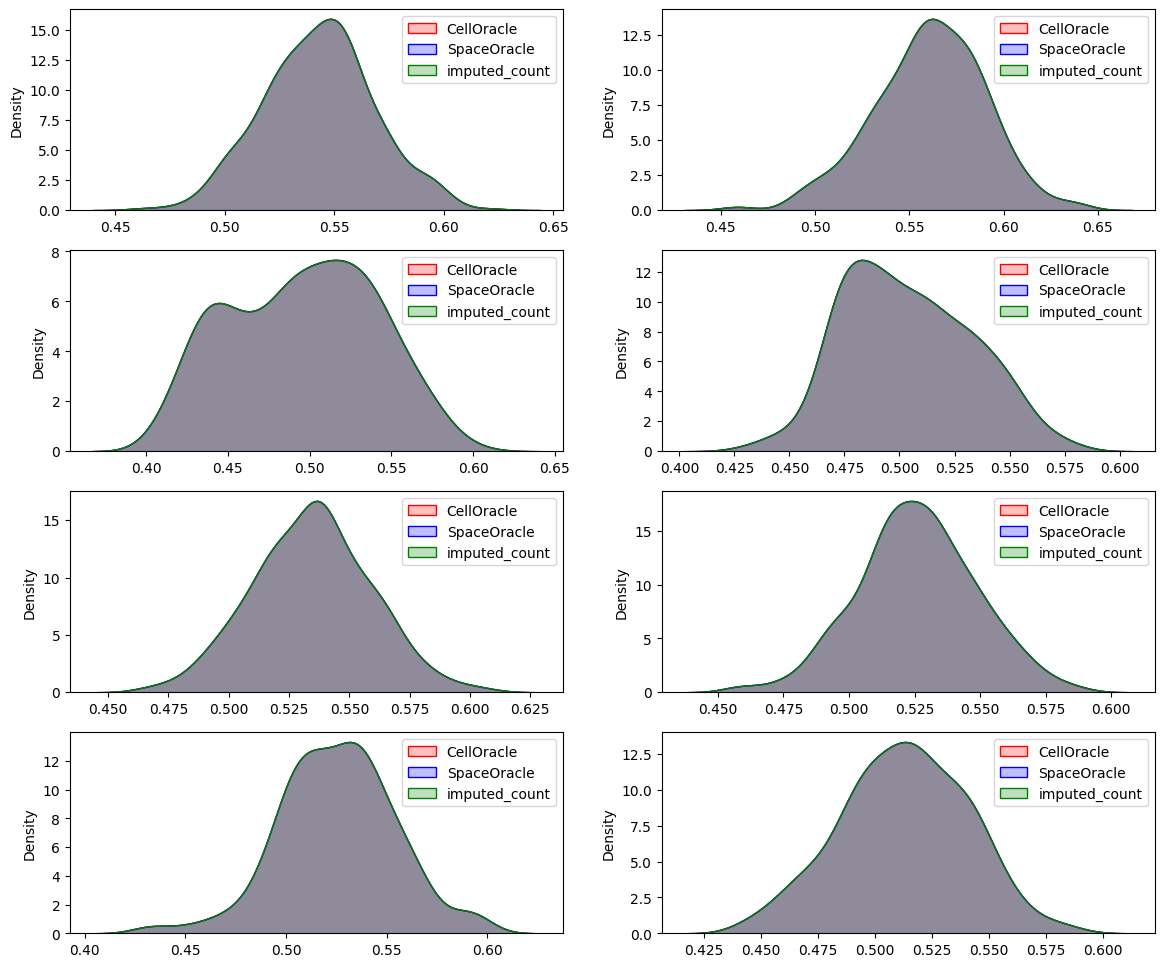

In [19]:
# all clusters
fig, axs = plt.subplots(4, 2, figsize=(14, 12))  # Adjust figure size as needed
axs = axs.flatten()  # Flatten the 4x2 grid into a 1D array of axes

for i, cluster in enumerate(sorted(clusters)):
    sns.kdeplot(adata_train.to_df(layer='perturbed_co')[so.adata.obs[so.annot] == cluster][gene].values, 
                label='CellOracle', color='red', shade=True, linewidth=1, ax=axs[i])
    sns.kdeplot(adata_train.to_df(layer='perturbed_so')[so.adata.obs[so.annot] == cluster][gene].values, 
                label='SpaceOracle', color='blue', shade=True, linewidth=1, ax=axs[i])
    sns.kdeplot(adata_train.to_df(layer='imputed_count')[so.adata.obs[so.annot] == cluster][gene].values, 
                label='imputed_count', color='green', shade=True, linewidth=1, ax=axs[i])

    # axs[i].set_title(f'cluster {cluster}: {cluster_labels[str(cluster)]}')
    axs[i].legend()

fig.delaxes(axs[-1]) 

plt.suptitle(f'Beta distributions on gene {gene} in each cluster from {goi} KO')
plt.tight_layout()
plt.show()

In [ ]:
from spaceoracle.tools.transitions import Transition

transition = COTransitions()
get_embed_spaces(so)

so.adata

In [ ]:
sc.pl.pca(adata_train, color='rctd_cluster', layer='imputed_count')


In [ ]:
sc.pl.umap(adata_train, color='rctd_cluster', layer='imputed_count')


In [ ]:
transition.estimate_transitions(so, embedding='X_spatial')